In [ ]:
# default_exp lightning.MSResNet

In [ ]:
# export
import importlib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import argparse
from collections import OrderedDict
from adamp import AdamP
import wandb

class GAN(pl.LightningModule):

    def __init__(self, hparams):
        super(GAN, self).__init__()
        
        self.hparams = hparams
        architecture = importlib.import_module('defocus.architecture.' + self.hparams.model_name)        
        self.G = architecture.Generator()
        self.D = architecture.Discriminator()
        
        data = importlib.import_module('defocus.data.' + self.hparams.model_name)        
        self.Dataset = data.Dataset
        
        self.adversarial_loss = self.set_weighted_loss(loss_functions=[getattr(nn, funcname)() for funcname in self.hparams.adv_loss[0::2]],
                                                  weights=[float(weight) for weight in self.hparams.adv_loss[1::2]],
                                                 )
        self.reconstruction_loss = self.set_weighted_loss(loss_functions=[getattr(nn, funcname)() for funcname in self.hparams.rec_loss[0::2]],
                                                  weights=[float(weight) for weight in self.hparams.rec_loss[1::2]],
                                                 )
        
        if self.hparams.per_loss is not None:
            # this is from DeblurGANv2
            # TODO: ESRGAN's perceptual loss version
            conv_3_3_layer = 14
            cnn = torchvision.models.vgg19(pretrained=True).features
            perceptual = nn.Sequential()
            perceptual = perceptual.eval()
            for i, layer in enumerate(list(cnn)):
                perceptual.add_module(str(i), layer)
                if i == conv_3_3_layer:
                    break
            self.P = perceptual
            self.perceptual_loss = self.set_weighted_loss(loss_functions=[getattr(nn, funcname)() for funcname in self.hparams.per_loss[0::2]],
                                                      weights=[float(weight) for weight in self.hparams.per_loss[1::2]],
                                                     )

        # cache for generated images
        self.generated_imgs = None
        self.last_imgs = None

    def set_weighted_loss(self, loss_functions=[nn.BCEWithLogitsLoss], weights=[1.0]):
        def weighted_loss(input_, target):
            total = 0
            for (func, weight) in zip(loss_functions, weights):
                total += func(input_, target)*weight
            return total
        return weighted_loss
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        betas = self.hparams.betas
        optimizer = self.hparams.optimizer
        
        if optimizer == 'AdamP':
            opt_g = AdamP(self.G.parameters(), lr=lr, betas=betas, weight_decay=0, nesterov=False)
            opt_d = AdamP(self.D.parameters(), lr=lr, betas=betas, weight_decay=0, nesterov=False)
        else:
            opt_g = torch.optim.Adam(self.G.parameters(), lr=lr, betas=betas, weight_decay=0)
            opt_d = torch.optim.Adam(self.D.parameters(), lr=lr, betas=betas, weight_decay=0)

        scheduler_d = torch.optim.lr_scheduler.MultiStepLR(opt_d, milestones=[500,750,900], gamma=0.5)
        scheduler_g = torch.optim.lr_scheduler.MultiStepLR(opt_g, milestones=[500,750,900], gamma=0.5)
        return [opt_d, opt_g], [scheduler_d, scheduler_g]    

    def train_dataloader(self):        
        train_dataset = self.Dataset(root_folder=self.hparams.root_folder, 
                                     image_pair_list=self.hparams.image_pair_list,
                                    )
        return DataLoader(train_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers)
    
#     def val_dataloader(self):        
#         val_dataset = self.Dataset(root_folder='/storage/projects/all_datasets/GOPRO/train/', 
#                                           image_pair_list='/storage/projects/all_datasets/GOPRO/train/val_image_pair_list.txt',
#                                          )
#         return DataLoader(val_dataset, batch_size=self.hparams.batch_size)

    def forward(self, input_):
        return self.G(input_)

    def training_step(self, batch, batch_idx, optimizer_idx):
        input_, target = batch
        self.last_imgs = input_
        
        output = self.G(input_)
        loss_g_rec = 0
        for scaled_output, scaled_target in zip(output, target):
            loss_g_rec += self.reconstruction_loss(scaled_output, scaled_target)
        high_res_output = output[-1]
        high_res_target = target[-1]

        # train discriminator
        if optimizer_idx == 0:
            d_fake = self.D(high_res_output.detach())
            d_real = self.D(high_res_target) 
            
            label_fake = torch.zeros_like(d_fake)
            label_real = torch.ones_like(d_real)
            if self.on_gpu:
                label_fake = label_fake.cuda(high_res_output.device.index)
                label_real = label_real.cuda(high_res_output.device.index)
                
            loss_d = self.adversarial_loss(d_fake, label_fake) + self.adversarial_loss(d_real, label_real)           
          
            tqdm_dict = {'loss_d': loss_d.item()}
            losses_and_logs = OrderedDict({
                'loss': loss_d,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return losses_and_logs

        # train generator
        if optimizer_idx == 1:            
            d_fake_with_gradient = self.D(high_res_output)
            
            label_real = torch.ones_like(d_fake_with_gradient)
            if self.on_gpu:
                label_real = label_real.cuda(high_res_output.device.index)
                
            loss_g_adversarial = self.adversarial_loss(d_fake_with_gradient, label_real)
            loss_g = loss_g_adversarial + loss_g_rec
            
            tqdm_dict = {'loss_g': loss_g, 'loss_g_adversarial': loss_g_adversarial}
            losses_and_logs = OrderedDict({
                'loss': loss_g,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return losses_and_logs

    def on_epoch_end(self):
        pass
        # not working, wandb does not upload the images
#         out = self(self.last_imgs)
#         image = out[-1][0].detach().cpu().numpy().transpose(1,2,0)
#         self.logger.experiment.log({"examples": [wandb.Image(image, caption="output")]})

In [ ]:
parser = argparse.ArgumentParser(description='It is time for more... experiments.')
parser.add_argument('--model_name', type=str, default='MSResNet', help='model name')
parser.add_argument('--batch_size', type=int, default=8, help='input batch size for training')
parser.add_argument('--num_workers', type=int, default=6, help='the number of dataloader workers')
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
parser.add_argument('--betas', type=float, nargs=2, default=(0.9, 0.999), help='ADAM betas')
parser.add_argument('--adv_loss', nargs='+', default=('BCEWithLogitsLoss', '1.0'), action='store', 
                    help='Adversarial loss function(s) and weighting, e.g. BCEWithLogitsLoss 0.5 MSELoss 0.5')
parser.add_argument('--rec_loss', nargs='+', default=('MSELoss', '1.0'), action='store',
                    help='Reconstruction loss function(s) and weighting, e.g. L1Loss 0.5 MSELoss 0.5')
parser.add_argument('--per_loss', nargs='+', action='store', 
                    help='Perceptual loss function(s) and weighting, e.g. L1Loss 0.5 MSELoss 0.5')
parser.add_argument('--optimizer', type=str, default='Adam', help='optimizer to use. currently Adam or AdamP')
parser.add_argument('--milestones', type=int, nargs='+', default=[500, 750, 900], help='learning rate decay per N epochs')
parser.add_argument('--root_folder', type=str, default='/storage/projects/all_datasets/GOPRO/train/', help='root folder')
parser.add_argument('--image_pair_list', type=str, default='/storage/projects/all_datasets/GOPRO/train/train_image_pair_list.txt', help='image list')
argv = ['--batch_size', '4', '--milestones', '50', '100', '150']
args = parser.parse_args(argv)

In [ ]:
args.milestones

[50, 100, 150]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
gan_model = GAN(args)

In [ ]:
loaded = torch.load('lightning_logs/checkpoints/epoch=50.ckpt', map_location='cpu')

In [ ]:
gan_model.load_state_dict(loaded['state_dict'])

<All keys matched successfully>

In [ ]:
for input_, target in gan_model.train_dataloader():
    output = gan_model(input_)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


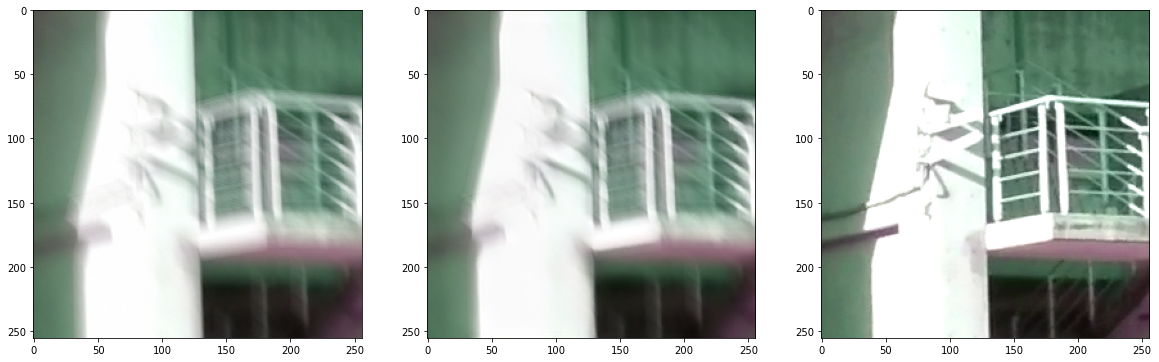

In [ ]:
batch_idx = 3
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow((input_[-1][batch_idx].detach().numpy().transpose(1,2,0))/255)
plt.subplot(132)
plt.imshow((output[-1][batch_idx].detach().numpy().transpose(1,2,0))/255)
plt.subplot(133)
plt.imshow((target[-1][batch_idx].detach().numpy().transpose(1,2,0))/255)

In [ ]:
from defocus.model import Model
import importlib
model_name = 'MSResNet'
architecture = importlib.import_module('defocus.architecture.' + model_name)

In [ ]:
loaded = torch.load('lightning_logs/checkpoints/epoch=99.ckpt')

In [ ]:
gan_model.load_state_dict(loaded['state_dict'])

<All keys matched successfully>

In [ ]:
model1_name = '14072020-singlegpu_bs_8_epoch_50.pth'
model2_name = '21202020-doublegpu_bs_8_Gbarrier/epoch_50.pth'
model = Model()
model.G = architecture.Generator()
model.D = architecture.Discriminator()
model.set_G_optimizer('AdamP')
model.set_D_optimizer('AdamP')
# model.load('19072020-doublegpu_bs_8/epoch_50.pth')
model.load(model1_name)
# model.load('epoch_75.pth')
# model.load('17072020-doublegpu_bs_16/epoch_60.pth')
model2 = Model()
model2.G = architecture.Generator()
model2.D = architecture.Discriminator()
model2.set_G_optimizer('AdamP')
model2.set_D_optimizer('AdamP')
# model2.load('19072020-doublegpu_bs_8/epoch_60.pth')
model2.load(model2_name)

In [ ]:
device = torch.device('cpu')
device2 = torch.device('cpu')

In [ ]:
model.to(device);
model2.to(device2);

In [ ]:
import random

In [ ]:
# seed=243948394
# seed=986896 # double better
# seed=675 # single better
seed = random.randint(0, 238782)
# seed=21237
print(seed)
random.seed(seed)
torch.manual_seed(seed)
for input_, target in gan_model.train_dataloader():
    break

73091


In [ ]:
with torch.no_grad():
    output = model.G(input_)
    print('model 1 done')
    output2 = model2.G(input_)
    print('model 2 done')
    output_lightning = gan_model(input_)
    print('model lightning done')

model 1 done
model 2 done
model lightning done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


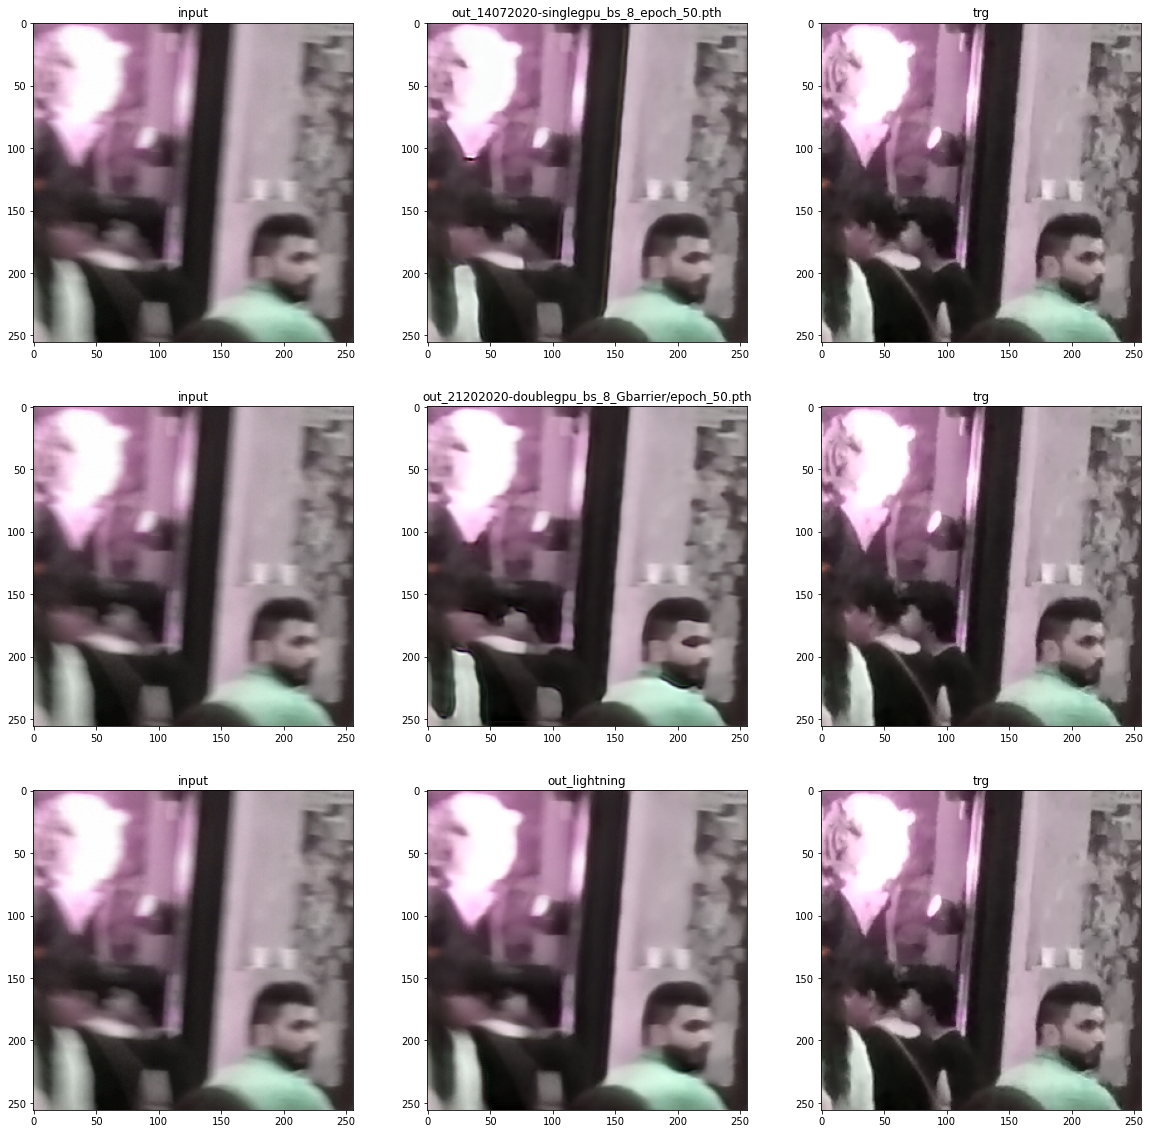

In [ ]:
batch_idx = random.randint(0,3)
inp = input_[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
trg = target[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
out1 = output[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
out2 = output2[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
out_lightning = output_lightning[-1][batch_idx].detach().cpu().numpy().transpose(1,2,0)
plt.figure(figsize=(20,20))

plt.subplot(331)
plt.title('input')
plt.imshow(inp/255)
plt.subplot(332)
plt.title('out_' + model1_name)
plt.imshow(out1/255)
plt.subplot(333)
plt.title('trg')
plt.imshow(trg/255)
plt.subplot(334)
plt.title('input')
plt.imshow(inp/255)
plt.subplot(335)
plt.title('out_' + model2_name)
plt.imshow(out2/255)
plt.subplot(336)
plt.title('trg')
plt.imshow(trg/255)
plt.subplot(337)
plt.title('input')
plt.imshow(inp/255)
plt.subplot(338)
plt.title('out_lightning')
plt.imshow(out_lightning/255)
plt.subplot(339)
plt.title('trg')
plt.imshow(trg/255)

plt.savefig('multigpu_compare/seed_{}.png'.format(seed))

In [ ]:
from nbdev.export import *
notebook2script()

Converted 01_model.ipynb.
Converted 02_architecture_common.ipynb.
Converted 03_architecture_MSResNet.ipynb.
Converted 04_dataset_common.ipynb.
Converted 05_dataset_MSResNet.ipynb.
Converted 06_trainer_MSResNet.ipynb.
Converted 99_diffaugment.ipynb.
Converted Tutorial.ipynb.
Converted lightning_trial.ipynb.
Converted trials.ipynb.
